In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats as sms

%matplotlib inline

def dms2dd(degrees, minutes, seconds):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    return dd

def danger_level(ppm: float) -> str:
    if ppm >= 1:
        return 'FDA'
    elif ppm >= 0.5:
        return 'Other States'
    elif ppm >= 0.43:
        return 'Maine'
    else:
        return 'Safe'
    
def mean_ci(sample, confidence=0.95):
    a = 1.0 * np.array(sample)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [2]:
df = pd.read_csv(
    'Assignment2_2022_Data.txt',
    sep=" ",
    names = ["NAME", "HG", "N", "ELV", "SA", "Z", "LT", "ST", "DA", "RF", "FR", "DAM", "LAT1", "LAT2", "LAT3", "LONG1", "LONG2", "LONG3"]
)
df.describe()

,HG,N,ELV,SA,Z,LT,ST,DA,RF,FR,DAM,LAT1,LAT2,LAT3,LONG1,LONG2,LONG3
count,120.000000,120.000000,120.000000,120.000000,119.000000,119.000000,118.000000,117.000000,113.000000,113.000000,118.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.485050,4.258333,567.283333,901.300000,41.201681,2.201681,0.559322,42.247863,0.550708,6.461062,0.601695,44.550000,28.141667,29.241667,68.833333,30.450000,30.583333
std,0.333267,1.088487,430.684196,1985.520644,29.980666,0.719932,0.498586,117.011413,0.099917,11.612443,0.491637,0.924458,16.730838,17.661617,0.964351,17.724242,15.770190
min,0.025000,1.000000,15.000000,12.000000,5.000000,1.000000,0.000000,0.000000,0.060000,0.100000,0.000000,43.000000,0.000000,0.000000,67.000000,0.000000,1.000000
25%,0.250000,4.000000,259.000000,79.750000,21.000000,2.000000,0.000000,2.000000,0.510000,0.900000,0.000000,44.000000,15.000000,13.000000,68.000000,15.750000,18.000000
50%,0.410000,5.000000,416.500000,236.500000,34.000000,2.000000,1.000000,6.000000,0.560000,2.100000,1.000000,44.000000,26.000000,28.000000,69.000000,31.500000,31.000000
75%,0.662500,5.000000,829.500000,632.000000,50.000000,3.000000,1.000000,21.000000,0.610000,5.800000,1.000000,45.000000,43.250000,45.000000,70.000000,46.000000,44.000000
max,2.500000,5.000000,1700.000000,14340.000000,158.000000,3.000000,1.000000,762.000000,0.760000,64.100000,1.000000,47.000000,59.000000,59.000000,71.000000,59.000000,59.000000


In [3]:
df.isna().sum(axis=0)

NAME     0
HG       0
N        0
ELV      0
SA       0
Z        1
LT       1
ST       2
DA       3
RF       7
FR       7
DAM      2
LAT1     0
LAT2     0
LAT3     0
LONG1    0
LONG2    0
LONG3    0
dtype: int64

In [4]:
df['N'].describe()

count    120.000000
mean       4.258333
std        1.088487
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: N, dtype: float64

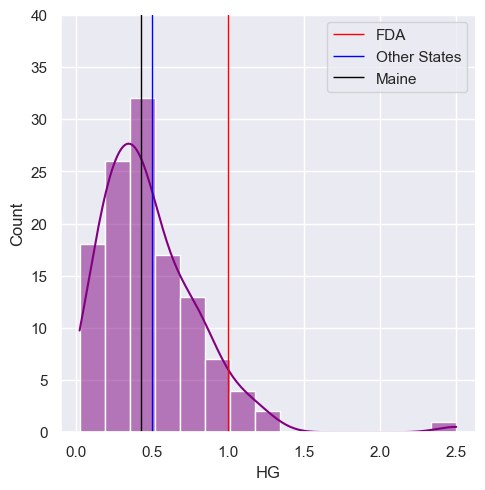

In [5]:
sns.set_theme()
p = sns.displot(df['HG'], kde=True, color = 'purple')
p.fig.set_dpi(100)
p.ax.set_xlabel('HG')
p.ax.set_ylabel('Count')
# p.ax.set_title('Mercury Histogram')
plt.vlines(1,0,100,label='FDA',color='red',linewidth=1)
plt.vlines(0.5,0,100,label='Other States',color='blue',linewidth=1)
plt.vlines(0.43,0,100,label='Maine',color='black',linewidth=1)
p.ax.set_ylim(0,40)
plt.legend()
plt.savefig('histogram.pdf', bbox_inches = 'tight')
plt.show()

- There could be reason to worry since there are some lakes above 1ppm, some lakes above 0.5ppm and some lakes above 0.43ppm
- The data is not normally distributed, which is a typicall assumption for a lot of models

In [6]:
fda_thresh = 1
other_states_thresh = 0.5
maine_thresh = 0.43

fda = df.loc[df['HG'] >= fda_thresh , 'NAME'].values.tolist()
other = df.loc[df['HG'] >= other_states_thresh , 'NAME'].values.tolist()
maine = df.loc[df['HG'] >= maine_thresh , 'NAME'].values.tolist()

print(f'Lakes over FDA level: {len(fda)}\n')
print(f'Lakes over the level for other states: {other}\n')
print(f'Lakes over maine level: {len(maine)}\n')

Lakes over FDA level: 7

Lakes over the level for other states: ['ALLEN.P', 'ANASAGUNTICOOK.L', 'BALCH&STUMP.PONDS', 'BASKAHEGAN.L', 'BAUNEAG.BEG.L', 'BELDEN.P', 'BOTTLE.L', 'BRADBURY(BARKER).L', 'BRANCH.L(SOUTH)', 'BRANCH.P(EAST)', 'BURNT.MEADOW.P', 'CANADA.FALLS.L', 'CEDAR.L', 'CHAIN.OF.PONDS', 'EAST.P', 'EMBDEN.P', 'FIELDS.P', 'FOLSOM.P', 'FOREST.L', 'GRAHAM.L', 'GRANGER.P', 'HICKS.P', 'HODGDON.P', 'HORSESHOE.L', 'JACOB.BUCK.P', 'JERRY.P', 'KEEWAYDIN.L', 'MACHIAS.L(FOURTH)', 'MOLUNKUS.L', 'NORTH.P', 'NORTH.P', 'ORANGE.L', 'OSSIPEE.L(LITTLE)', 'PASSAGASSAWAUKEAG.L', 'PINE.P(BIG)', 'PITCHER.P', 'PLEASANT.P', 'PORTLAND.L', 'RANGE.P(LOWER)', 'ROBERTS&WADLEY.PDS', 'ROCKY.P', 'ROUND(GREY).P', 'ROUND.P', 'SECOND.L', 'TRAVEL.P']

Lakes over maine level: 59



In [7]:
maine.append('')
pretty_df = pd.DataFrame({'': maine[:10], ' ': maine[10:20], '  ': maine[20:30], '   ':maine[30:40], '    ':maine[40:50], '     ':maine[50:60]})
pretty_df

,,,,,,
0,ALLEN.P,BRANCH.P(UPPER.MID),EMBDEN.P,JERRY.P,ORANGE.L,ROCKY.P
1,ANASAGUNTICOOK.L,BURDEN.P,FIELDS.P,JUMP.P,OSSIPEE.L(LITTLE),ROUND(GREY).P
2,BALCH&STUMP.PONDS,BURNT.MEADOW.P,FOLSOM.P,KEEWAYDIN.L,PASSAGASSAWAUKEAG.L,ROUND.P
3,BASKAHEGAN.L,CANADA.FALLS.L,FOREST.L,LAMBERT.L,PINE.P(BIG),ROUND.P
4,BAUNEAG.BEG.L,CEDAR.L,GRAHAM.L,LOVEWELL.P,PITCHER.P,SECOND.L
5,BELDEN.P,CHAIN.OF.PONDS,GRANGER.P,MACHIAS.L(FOURTH),PLEASANT.L,SHIN.P(LOWER)
6,BOTTLE.L,CHASE.L,HICKS.P,MOLUNKUS.L,PLEASANT.P,TRAVEL.P
7,BRADBURY(BARKER).L,DEBSCONEAG.L(4TH),HODGDON.P,MOOSELEUK.L,PORTLAND.L,UMCOLCUS.L
8,BRANCH.L(SOUTH),EAGLE.L,HORSESHOE.L,NORTH.P,RANGE.P(LOWER),WIGHT.P
9,BRANCH.P(EAST),EAST.P,JACOB.BUCK.P,NORTH.P,ROBERTS&WADLEY.PDS,


In [8]:
# H_0: mean = 0.43, H_1: mean > 0.43
sp.stats.ttest_1samp(df['HG'].values, popmean=0.43, alternative='greater')

Ttest_1sampResult(statistic=1.8094886950044202, pvalue=0.03644963387894092)

In [9]:
# add real latitude and longitude
df['LAT'] = df.apply(lambda row: dms2dd(row.LAT1, row.LAT2, row.LAT3), axis = 1)
df['LONG'] = -df.apply(lambda row: dms2dd(row.LONG1, row.LONG2, row.LONG3), axis = 1)
df['danger_level'] = df.apply(lambda row: danger_level(row.HG), axis = 1 )

In [10]:
geometry = [Point(xy) for xy in zip(df['LONG'], df['LAT'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
maine = pd.read_csv('data/maine_boundaries.csv')
maine.head()

,lng,lat
0,-71.0129,45.3425
1,-70.9525,45.3328
2,-70.8618,45.2294
3,-70.8247,45.3917
4,-70.7808,45.4274


## Visualizing the Data

C:\Users\antho\AppData\Local\Temp\ipykernel_3252\1026682146.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


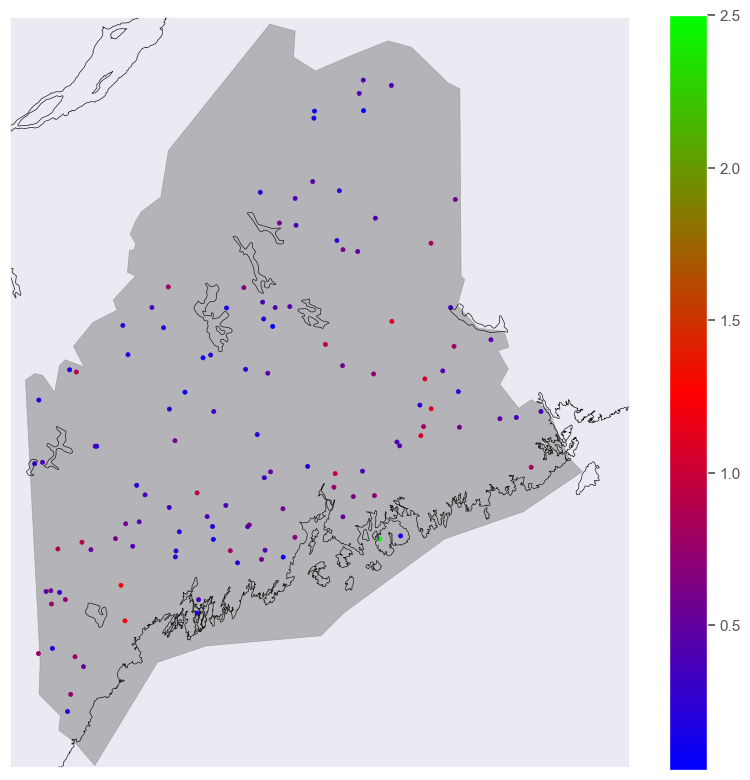

In [11]:
fig, ax = plt.subplots(figsize=(10,10), dpi = 100)

plt.style.use('ggplot')

m = Basemap(projection='mill',
            llcrnrlat = 42.9,
            llcrnrlon = -71.2,
            urcrnrlat = 47.5,
            urcrnrlon = -66.5,
            resolution = 'h')

#m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(linewidth=0.5)
# m.drawcountries(linewidth=1,color='r')
# m.drawstates(linewidth=1, color='r')
# m.drawrivers(linewidth=0.5, color='b')
# m.fillcontinents()
x,y = m(maine['lng'].values, maine['lat'].values)
plt.fill(x,y, color = 'grey', alpha = 0.5)
x,y=m(df['LONG'], df['LAT'])
plt.scatter(x, y, marker = '.', c= df['HG'], cmap = 'brg')
# plt.title('Mercury Levels', fontsize=15,fontweight='bold')
plt.colorbar()
plt.savefig('mercury_levels_geo.pdf', bbox_inches = 'tight')
plt.show()

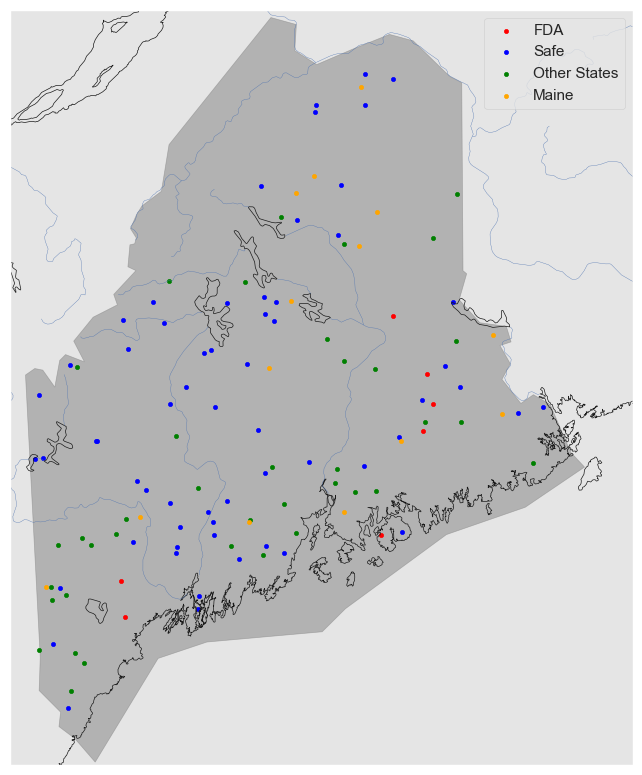

In [12]:
fig, ax = plt.subplots(figsize=(10,10), dpi = 100)

plt.style.use('ggplot')

colors = ['red', 'blue', 'green', 'orange']

m = Basemap(projection='mill',
            llcrnrlat = 42.9,
            llcrnrlon = -71.2,
            urcrnrlat = 47.5,
            urcrnrlon = -66.5,
            resolution = 'h')

#m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(linewidth=0.5)
# m.drawcountries(linewidth=1,color='r')
# m.drawstates(linewidth=1, color='r')
m.drawrivers(linewidth=0.25, color='b')
# m.fillcontinents()
x,y = m(maine['lng'].values, maine['lat'].values)
plt.fill(x,y, color = 'grey', alpha = 0.5)

classes = df['danger_level'].unique()

for i in range(len(classes)):
    temp = df.loc[df['danger_level'].values == classes[i] ,:]
    x,y=m(temp['LONG'], temp['LAT'])
    plt.scatter(x, y, marker = '.', c= colors[i], label = classes[i])

# plt.title('Danger Levels', fontsize=15,fontweight='bold')
plt.legend()
plt.savefig('mercury_danger_geo.pdf', bbox_inches = 'tight')
plt.show()

## Checking Relationship Between Mercury and Human Infrastructure

118
PointbiserialrResult(correlation=-0.10514081194004549, pvalue=0.2571692085114729)
Intercept        3.203530e-19
C(DAM)[T.1.0]    2.571692e-01
dtype: float64
             sum_sq     df         F    PR(>F)
C(DAM)     0.145946    1.0  1.296667  0.257169
Residual  13.056348  116.0       NaN       NaN
           HG
DAM          
0.0  0.528106
1.0  0.456268
Mean Confidence Interval No Dam: (0.43642420640418655, 0.6197885595532602)
Mean Confidence Interval Dam: (0.3734426249513017, 0.5390925863163037)


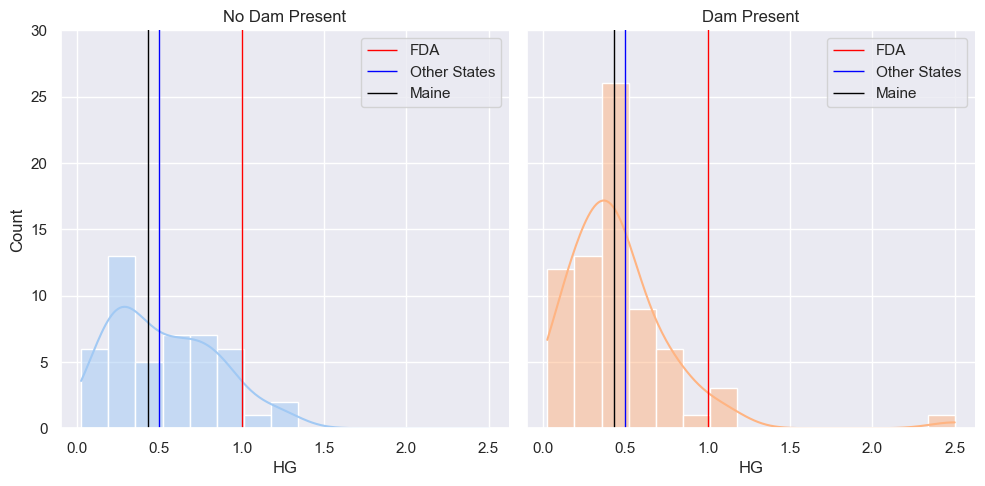

In [13]:
# get non NA indexes
indexes = np.where(~(df['DAM'].isna() | df['HG'].isna()))[0]
print(len(indexes))

print(sp.stats.pointbiserialr(df['DAM'].values[indexes], df['HG'].values[indexes]))

# Ordinary Least Squares (OLS) model
model = ols('HG ~ C(DAM)', data=df.iloc[indexes, :]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.pvalues)
print(anova_table)

# mean of groups
print(df[['HG', 'DAM']].groupby(by='DAM', axis=0).mean())
# confidence interval of groups
print(f'Mean Confidence Interval No Dam: {mean_ci(df["HG"][df["DAM"]==0])}')
print(f'Mean Confidence Interval Dam: {mean_ci(df["HG"][df["DAM"]==1])}')

sns.set_theme()
p = sns.displot(df[['HG', 'DAM']], x = 'HG', kde=True, hue = 'DAM', col = 'DAM', palette='pastel', legend=False, height = 5)
p.fig.set_dpi(100)
# p.fig.suptitle('Mercury Levels Versus Presence of Dam', fontsize=15, fontweight='bold', y=1.05)
p.axes[0][0].set_title('No Dam Present')
p.axes[0][1].set_title('Dam Present')

for ax in p.axes[0]:
    ax.vlines(1,0,100,label='FDA',color='red',linewidth=1)
    ax.vlines(0.5,0,100,label='Other States',color='blue',linewidth=1)
    ax.vlines(0.43,0,100,label='Maine',color='black',linewidth=1)
    ax.set_ylim(0,30)
    ax.legend()
plt.savefig('histogram_dam.pdf', bbox_inches = 'tight')
plt.show()

In [14]:
reduced_model = ols('HG ~ 1', data=df.iloc[indexes, :]).fit()

print(model.compare_lr_test(reduced_model))

(1.3117052741217776, 0.2520861381790492, 1.0)


***
The data does not support the claim
- correlation between the variables is low and insignificant
- there is not a significant difference in the groups of lakes with a dam and those without a dam
- The model including the DAM predictor is not better in terms of model likelihood than the baseline model, so the presence of a DAM is not significant

## Checking Relationship Between Mercury and Lake Type

119
F_onewayResult(statistic=2.2341903249006134, pvalue=0.11166708200439195)
                            OLS Regression Results                            
Dep. Variable:                     HG   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.234
Date:                Tue, 15 Feb 2022   Prob (F-statistic):              0.112
Time:                        16:23:20   Log-Likelihood:                -35.805
No. Observations:                 119   AIC:                             77.61
Df Residuals:                     116   BIC:                             85.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

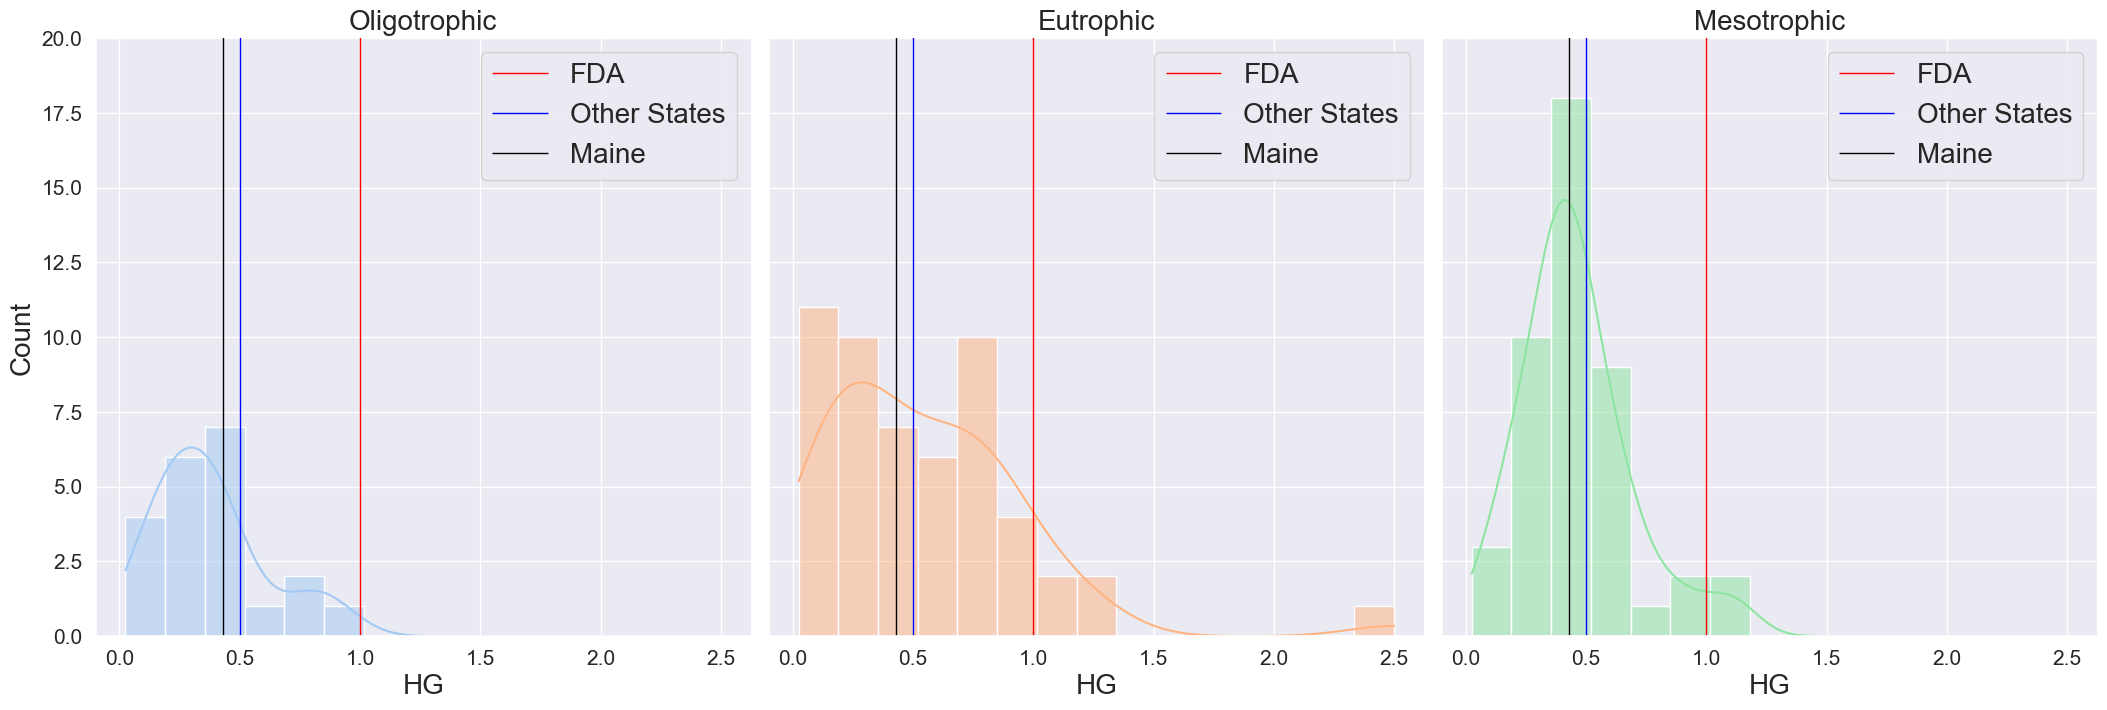

In [15]:
# get non NA indexes
indexes = np.where(~(df['LT'].isna() | df['HG'].isna()))[0]
print(len(indexes))

print(sp.stats.f_oneway(df['HG'][df['LT']==1], df['HG'][df['LT']==2], df['HG'][df['LT']==3]))

# Ordinary Least Squares (OLS) model
model = ols('HG ~ C(LT)', data=df.iloc[indexes, :]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print(model.pvalues)
print(anova_table)
print(df[['HG', 'LT']].groupby(by='LT', axis=0).mean())
# confidence interval of groups
print(f'Mean Confidence Interval Oligotrophic Lakes: {mean_ci(df["HG"][df["LT"]==1])}')
print(f'Mean Confidence Interval Eutrophic Lakes: {mean_ci(df["HG"][df["LT"]==2])}')
print(f'Mean Confidence Interval Mesotrophic Lakes: {mean_ci(df["HG"][df["LT"]==3])}')



sns.set_theme()
p = sns.displot(df[['HG', 'LT']], x = 'HG', kde=True, hue = 'LT', col = 'LT', palette='pastel', legend = False, height = 7)
p.fig.set_dpi(100)
p.set_xlabels('HG', fontsize=20)
p.set_ylabels('Count', fontsize=20)

# p.fig.suptitle('Mercury Levels Versus Lake Type', fontsize=15, fontweight='bold', y=1.05)
p.axes[0][0].set_title('Oligotrophic', fontdict = {'fontsize':20})
p.axes[0][1].set_title('Eutrophic', fontdict = {'fontsize':20})
p.axes[0][2].set_title('Mesotrophic', fontdict = {'fontsize':20})

for ax in p.axes[0]:
    ax.vlines(1,0,100,label='FDA',color='red',linewidth=1)
    ax.vlines(0.5,0,100,label='Other States',color='blue',linewidth=1)
    ax.vlines(0.43,0,100,label='Maine',color='black',linewidth=1)
    ax.set_ylim(0,20)
    ax.legend(prop={'size': 20})
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    

plt.savefig('histogram_lt.pdf', bbox_inches = 'tight')
plt.show()

In [16]:
reduced_model = ols('HG ~ 1', data=df.iloc[indexes, :]).fit()

print(model.compare_lr_test(reduced_model))

(4.497858011213509, 0.10551216700999114, 2.0)


In [17]:
anova_table.columns = ['Sum of Squares', 'df', 'F', 'p-value']
anova_table.index = ['Lake Type', 'Residual']
anova_table.iloc[1,2] = '-'
anova_table.iloc[1,3] = '-'
anova_table

,Sum of Squares,df,F,p-value
Lake Type,0.489902,2.0,2.23419,0.111667
Residual,12.717952,116.0,-,-


In [18]:
lt1 = mean_ci(df["HG"][df["LT"]==1])
lt2 = mean_ci(df["HG"][df["LT"]==2])
lt3 = mean_ci(df["HG"][df["LT"]==3])
pd.DataFrame({'Lower Bound': [lt1[0], lt2[0], lt3[0]], 'Upper Bound': [lt1[1], lt2[1], lt3[1]]}, index = ['Oligotrophic', 'Eutrophic', 'Mesotrophic'])

,Lower Bound,Upper Bound
Oligotrophic,0.272705,0.479676
Eutrophic,0.431005,0.665410
Mesotrophic,0.390929,0.527783


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HG   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.234
Date:                Tue, 15 Feb 2022   Prob (F-statistic):              0.112
Time:                        16:23:22   Log-Likelihood:                -35.805
No. Observations:                 119   AIC:                             77.61
Df Residuals:                     116   BIC:                             85.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3762      0.072      5.206      0.000       0.233       0.519
C(LT)[T.2.0]     0.1720      0.085      2.015      0.046       0.003       0.341
C(LT)[T.3.0]     0.0832      0.088      0.950      0.344      -0.090       0.256
==============================================================================
Omnibus:                       73.405   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              483.704
Skew:                           1.999   Prob(JB):                    9.23e-106
Kurtosis:                      12.032   Cond. No.                         5.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***

There is not evidence supporting that the three different lake types have different levels of mercury concentration
- The data shows that the descending ranking of concentration by lake type is Eutrophic, Mesotrophic, Oligotrophic
- The model including the lake type predictor is not better in terms of model likelihood than the baseline model, so the different lake types are not significant

However this is specific for Maine and does not indicate that in general lake types have varying mercury levels.
This is also based on a quite small sample size so means that we may not have too much confidence in the estimate.